In [126]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pylab
import statsmodels.formula.api as smf

from scipy.stats import norm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectPercentile
from statsmodels.graphics.gofplots import ProbPlot
from statsmodels.compat import lzip
from sklearn.preprocessing import PolynomialFeatures

import warnings
warnings.filterwarnings("ignore")


In [127]:
data = pd.read_csv("car data.csv") # read the data as a csv file 

In [128]:
data.head(5) # first 5 rows 


,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


In [129]:
data.isnull().any() # we have no missing values 
data.isnull().sum() # in the event in which we did have missing values, this would tell us how many 

Car_Name         0
Year             0
Selling_Price    0
Present_Price    0
Kms_Driven       0
Fuel_Type        0
Seller_Type      0
Transmission     0
Owner            0
dtype: int64

In [130]:
data.describe() # get summary statistics of each column in the dataset 

,Year,Selling_Price,Present_Price,Kms_Driven,Owner
count,301.000000,301.000000,301.000000,301.000000,301.000000
mean,2013.627907,4.661296,7.628472,36947.205980,0.043189
std,2.891554,5.082812,8.644115,38886.883882,0.247915
min,2003.000000,0.100000,0.320000,500.000000,0.000000
25%,2012.000000,0.900000,1.200000,15000.000000,0.000000
50%,2014.000000,3.600000,6.400000,32000.000000,0.000000
75%,2016.000000,6.000000,9.900000,48767.000000,0.000000
max,2018.000000,35.000000,92.600000,500000.000000,3.000000


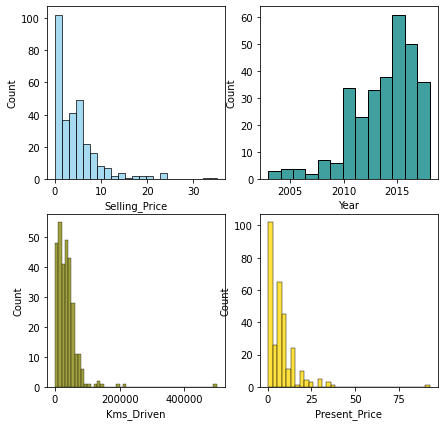

In [131]:
fig, axs = plt.subplots(2, 2, figsize=(7, 7))

sns.histplot(data["Selling_Price"], color = "skyblue", ax=axs[0, 0])
sns.histplot(data["Year"], color = "teal", ax=axs[0, 1])
sns.histplot(data["Kms_Driven"], color = "olive", ax=axs[1, 0])
sns.histplot(data["Present_Price"], color = "gold", ax=axs[1, 1])



From the plots above, we see that the selling price is not normally distributed. This fails one of the multiple linear regression assumptions. Let's transform the Selling Price by taking the log of all values. 


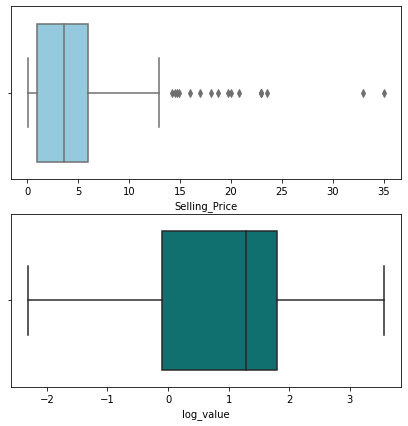

In [132]:
data['log_value'] = np.log(data['Selling_Price'])

selling_price = data["Selling_Price"]

log_value = data['log_value']


fig, axs = plt.subplots(2, 1, figsize=(7, 7))

sns.boxplot(data["Selling_Price"], color = "skyblue", ax=axs[0])
sns.boxplot(data["log_value"], color = "teal", ax=axs[1])

# here we can see that after the log transformation, log of selling price follows bell shape slightly closer. 


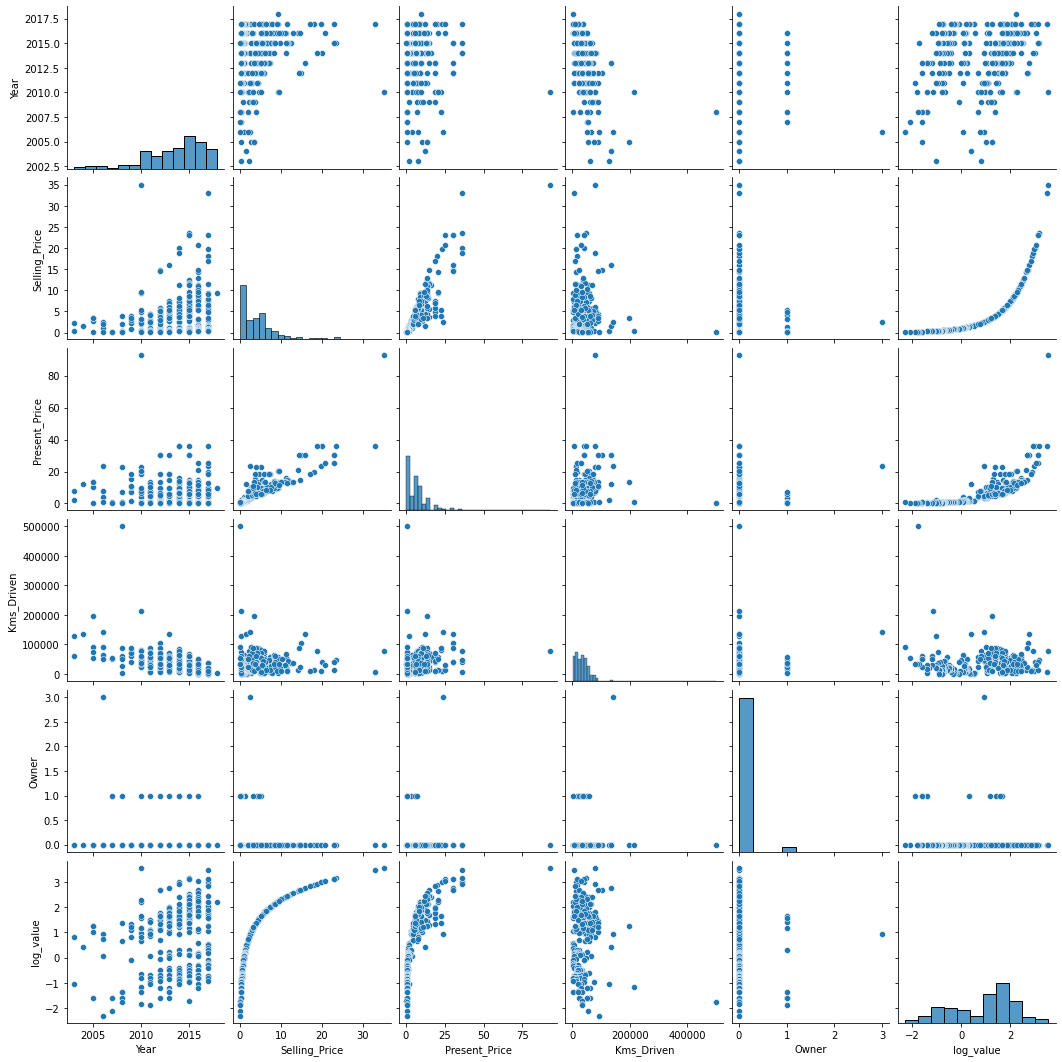

In [123]:
sns.pairplot(data) 

It seems that the owner covariate may not be very useful. Therefore let's perform model variable selection next. 

In [133]:
Categorical_Covariates = ['Car_Name',	'Fuel_Type',	'Seller_Type',	'Transmission',	'Owner'] # Crate a list of categorical covariates 

data_observations = data.drop(["Selling_Price", "log_value"], axis = 1)

data_target = data["log_value"]

data_new = pd.get_dummies(data_observations, columns = Categorical_Covariates) #convert categorical variables to dummy variables. 


In [52]:
#mask = select.get_support() 

cols = data_new.columns

def ols_model():
   Regressors  = []

   for i in range(0,len(cols)): 
    name = cols[i]
    name = name.replace(" ", "")
    name = name.replace(".", "")
    Regressors.append(name)


   Model = 'log_value ~ '

   for i in range(0,len(Regressors)): 
    if i == len(Regressors) - 1:
      add = Regressors[i]
      add = add.replace(" ", "")
      Model += add.replace(".", "")
  
    else: 
      add = Regressors[i]
      add += "+"
      Model += add.replace(" ", "")


   Remove_Cols  = []
   for i in range(0,len(cols)): 
    name = cols[i]
    name = name
    Remove_Cols.append(name)

   return(Regressors, Remove_Cols, Model)




In [53]:
Regressors, Remove_Cols, Model = ols_model()

data_new = data_new.set_axis(Regressors, axis=1)

# Fit regression model (using the natural log of one of the regressors)
results = smf.ols(Model, data=data_new).fit()

# Inspect the results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              log_value   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     243.8
Date:                Fri, 27 Aug 2021   Prob (F-statistic):          3.46e-167
Time:                        16:40:44   Log-Likelihood:                 236.26
No. Observations:                 301   AIC:                            -260.5
Df Residuals:                     195   BIC:                             132.4
Df Model:                         105                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

To produce a simpler model, we will perform forward selection based on the p-value of each parameter estimate. 

In [43]:
interaction = PolynomialFeatures(include_bias=False, interaction_only=True)
X_inter = interaction.fit_transform(data_new)

cols = interaction.get_feature_names(Regressors)

def ols_model():
   Regressors  = []

   for i in range(0,len(cols)): 
    name = cols[i]
    name = name.replace(" ", "")
    name = name.replace(".", "")
    Regressors.append(name)


   Model = 'log_value ~ '

   for i in range(0,len(Regressors)): 
    if i == len(Regressors) - 1:
      add = Regressors[i]
      add = add.replace(" ", "")
      Model += add.replace(".", "")
  
    else: 
      add = Regressors[i]
      add += "+"
      Model += add.replace(" ", "")


   Remove_Cols  = []
   for i in range(0,len(cols)): 
    name = cols[i]
    name = name
    Remove_Cols.append(name)

   return(Regressors, Remove_Cols, Model)

Regressors, Remove_Cols, Model = ols_model()


data_new = data_new.set_axis(Regressors, axis=1)


results = smf.ols(Model, data=data_new).fit()

# Inspect the results
print(results.summary())


ValueError: ignored

In [65]:
import sys
sys.setrecursionlimit(100000)

interaction = PolynomialFeatures(include_bias=False, interaction_only=True)
data_new_interactions_array = interaction.fit_transform(data_new)
cols = interaction.get_feature_names(Regressors)


def ols_model():
   Regressors  = []

   for i in range(0,len(cols)): 
    name = cols[i]
    name = name.replace(" ", "")
    name = name.replace(".", "")
    Regressors.append(name)


   Model = 'log_value ~ '

   for i in range(0,len(Regressors)): 
    if i == len(Regressors) - 1:
      add = Regressors[i]
      add = add.replace(" ", "")
      Model += add.replace(".", "")
  
    else: 
      add = Regressors[i]
      add += "+"
      Model += add.replace(" ", "")


   Remove_Cols  = []
   for i in range(0,len(cols)): 
    name = cols[i]
    name = name
    Remove_Cols.append(name)

   return(Regressors, Remove_Cols, Model)

Regressors, Remove_Cols, Model = ols_model()

data_new_Interactions = pd.DataFrame(data_new_interactions_array, columns = Regressors)


results = smf.ols(Model, data=data_new_Interactions).fit()

# Inspect the results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              log_value   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     434.8
Date:                Fri, 27 Aug 2021   Prob (F-statistic):           8.18e-72
Time:                        16:54:06   Log-Likelihood:                 608.87
No. Observations:                 301   AIC:                            -745.7
Df Residuals:                      65   BIC:                             129.1
Df Model:                         235                                         
Covariance Type:            nonrobust                                         
                                                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

In [62]:
print(data_new_Interactions)

       Year  Present_Price  ...  Owner_0Owner_3  Owner_1Owner_3
0    2014.0           5.59  ...             0.0             0.0
1    2013.0           9.54  ...             0.0             0.0
2    2017.0           9.85  ...             0.0             0.0
3    2011.0           4.15  ...             0.0             0.0
4    2014.0           6.87  ...             0.0             0.0
..      ...            ...  ...             ...             ...
296  2016.0          11.60  ...             0.0             0.0
297  2015.0           5.90  ...             0.0             0.0
298  2009.0          11.00  ...             0.0             0.0
299  2017.0          12.50  ...             0.0             0.0
300  2016.0           5.90  ...             0.0             0.0

[301 rows x 6216 columns]


In [134]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs


X_train, X_test, y_train, y_test = train_test_split(data_new, data_target, random_state=0)

clf = LinearRegression()


sfs1 = sfs(clf,k_features = 5,forward=True,floating=False, scoring='r2',cv=5)

# Perform SFFS
sfs1 = sfs1.fit(X_train, y_train)



In [135]:
cols = list(sfs1.k_feature_names_)


In [136]:
original_cols = data_new.columns

def ols_model():
   Regressors  = []

   for i in range(0,len(original_cols)): 
    name = cols[i]
    name = name.replace(" ", "")
    name = name.replace(".", "")
    Regressors.append(name)


   Model = 'log_value ~ '

   for i in range(0,len(Regressors)): 
    if i == len(Regressors) - 1:
      add = Regressors[i]
      add = add.replace(" ", "")
      Model += add.replace(".", "")
  
    else: 
      add = Regressors[i]
      add += "+"
      Model += add.replace(" ", "")


   Remove_Cols  = []
   for i in range(0,len(cols)): 
    name = cols[i]
    name = name
    Remove_Cols.append(name)

   return(Regressors, Remove_Cols, Model)

In [137]:
Regressors, Remove_Cols, Model = ols_model()

final_data = data_new.drop(labels = Remove_Cols, axis = 1)

In [139]:
Remove_Cols

['Year',
 'Present_Price',
 'Car_Name_land cruiser',
 'Fuel_Type_Diesel',
 'Seller_Type_Dealer']